==== Merged Data: Head ====
     Quarter  quarterly revenue  quarterly gross profit  quarterly net income  \
0 2020-03-31       1.185000e+09             689000000.0            83000000.0   
1 2020-06-30       4.850000e+08             264000000.0          -244000000.0   
2 2020-09-30       6.980000e+08             424000000.0             5000000.0   
3 2020-12-31       8.200000e+08             524000000.0            42000000.0   
4 2021-03-31       1.122000e+09             679000000.0            82000000.0   

                                               Title       Views     Likes  \
0  winter clothing tryon haul (Urban Outfitters, ...    178520.0    4416.0   
1  📖 Genialne Fantasy! -  Joe Abercrombie Trylogi...  15366278.0  149656.0   
2  BEST PETITE DENIM JEANS TRY-ON & REVIEW / Levi...    338531.0   10457.0   
3  A&F 90's Straight Ultra High Rise Jean Review ...  15216055.0   82214.0   
4  Abercrombie and Fitch + Hollister TRY-ON HAUL ...   8583548.0   92132.0   

   Comments     

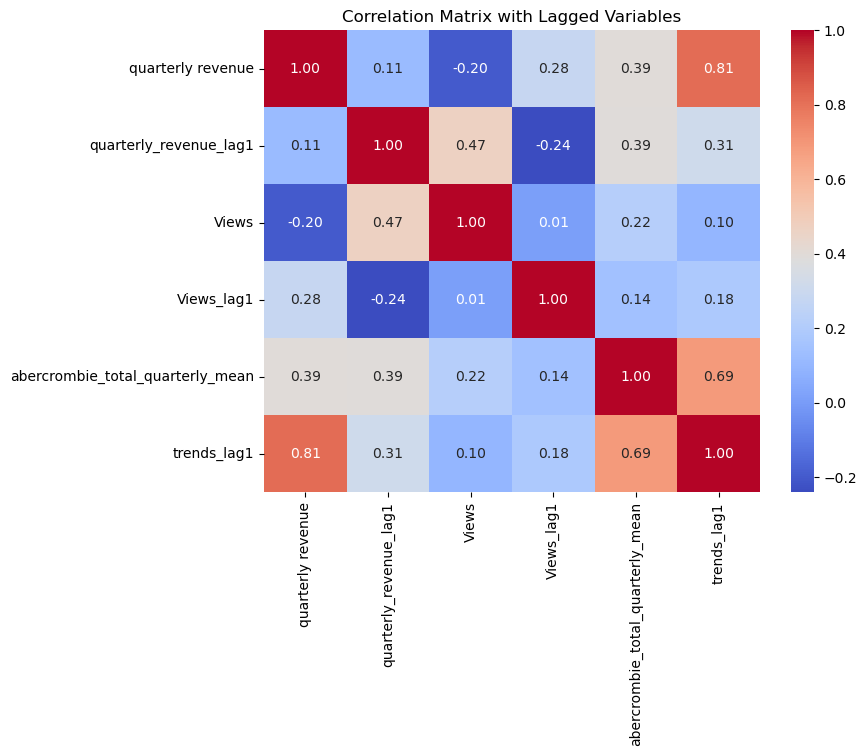

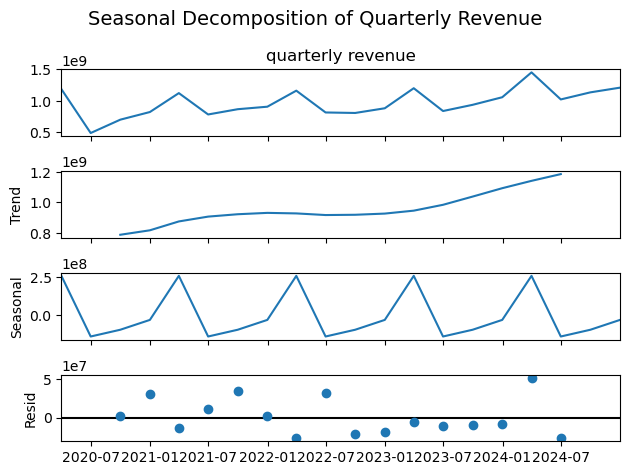


==== OLS Regression Model Summary ====
                            OLS Regression Results                            
Dep. Variable:      quarterly revenue   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     2.704
Date:                Sat, 08 Feb 2025   Prob (F-statistic):             0.0956
Time:                        11:33:52   Log-Likelihood:                -409.59
No. Observations:                  20   AIC:                             825.2
Df Residuals:                      17   BIC:                             828.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

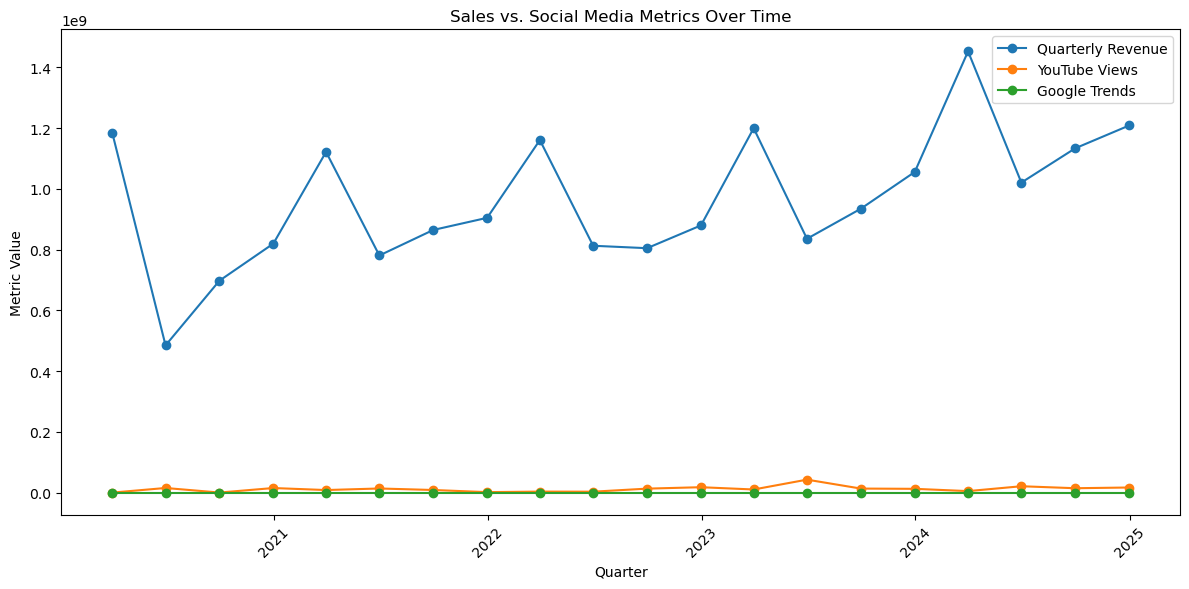

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# =============================================================================
# PRELIMINARY: Load and Inspect the Merged Dataset
# =============================================================================
# Load the merged quarterly data which includes sales, YouTube, and Google Trends metrics.
df_final_clean = pd.read_csv(r"C:\Users\Admin\final_capstone_project\data\processed\merged_quarterly_data.csv")

# Convert the "Quarter" column to datetime format and sort by time.
df_final_clean["Quarter"] = pd.to_datetime(df_final_clean["Quarter"], errors="coerce")
df_final_clean.sort_values("Quarter", inplace=True)

# Print a basic inspection of the data.
print("==== Merged Data: Head ====")
print(df_final_clean.head())
print("\n==== DataFrame Info ====")
print(df_final_clean.info())

# =============================================================================
# STEP 1: LAG ANALYSIS
# =============================================================================
# Objective: Check if last quarter's social media metrics (lagged values) are related
# to this quarter's sales by creating lagged variables and computing their correlations.

# Create lagged variables (one-quarter lag) for key metrics.
df_final_clean["quarterly_revenue_lag1"] = df_final_clean["quarterly revenue"].shift(1)
df_final_clean["Views_lag1"] = df_final_clean["Views"].shift(1)
df_final_clean["trends_lag1"] = df_final_clean["abercrombie_total_quarterly_mean"].shift(1)

# Define the list of columns to include in the correlation analysis.
lag_cols = [
    "quarterly revenue", "quarterly_revenue_lag1",
    "Views", "Views_lag1",
    "abercrombie_total_quarterly_mean", "trends_lag1"
]

# Compute and display the correlation matrix for these variables.
lag_corr = df_final_clean[lag_cols].corr()
print("\n==== Lag Correlation Matrix ====")
print(lag_corr)

# Plot the correlation matrix as a heatmap.
plt.figure(figsize=(8,6))
sns.heatmap(lag_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix with Lagged Variables")
plt.show()

# =============================================================================
# STEP 2: SEASONAL DECOMPOSITION OF SALES
# =============================================================================
# Objective: Decompose the quarterly revenue time series into its trend, seasonal,
# and residual components to understand underlying patterns.

# Set "Quarter" as the index for time series analysis and sort.
df_sales_ts = df_final_clean.set_index("Quarter").sort_index()

# Perform seasonal decomposition on quarterly revenue using an additive model.
# For quarterly data, we assume 4 quarters per year (period=4).
decomposition = seasonal_decompose(df_sales_ts["quarterly revenue"], model='additive', period=4)

# Plot the decomposition results.
decomposition.plot()
plt.suptitle("Seasonal Decomposition of Quarterly Revenue", fontsize=14)
plt.tight_layout()
plt.show()

# =============================================================================
# STEP 3: REGRESSION ANALYSIS
# =============================================================================
# Objective: Build an OLS regression model to quantify the relationship between
# social media metrics (YouTube Views and Google Trends) and quarterly revenue.

# Define the independent variables (predictors) and the dependent variable (sales).
X = df_final_clean[["Views", "abercrombie_total_quarterly_mean"]]
y = df_final_clean["quarterly revenue"]

# Add a constant term to the predictors for the regression intercept.
X = sm.add_constant(X)

# Fit the OLS regression model, dropping any rows with missing values.
model = sm.OLS(y, X, missing='drop').fit()

# Print the regression summary.
print("\n==== OLS Regression Model Summary ====")
print(model.summary())

# =============================================================================
# STEP 4: VISUALIZATION OF COMBINED TRENDS OVER TIME
# =============================================================================
# Objective: Overlay quarterly sales, YouTube Views, and Google Trends metrics to
# visually assess how these variables change over time.

plt.figure(figsize=(12,6))

# Plot quarterly revenue.
plt.plot(df_final_clean["Quarter"], df_final_clean["quarterly revenue"], marker="o", label="Quarterly Revenue")

# Plot YouTube Views.
plt.plot(df_final_clean["Quarter"], df_final_clean["Views"], marker="o", label="YouTube Views")

# Plot Google Trends metric.
plt.plot(df_final_clean["Quarter"], df_final_clean["abercrombie_total_quarterly_mean"], marker="o", label="Google Trends")

# Add labels, title, and legend.
plt.xlabel("Quarter")
plt.ylabel("Metric Value")
plt.title("Sales vs. Social Media Metrics Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
